In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler


import torchvision.datasets as dset
import torchvision.transforms as T

import matplotlib.pyplot as plt

import torch.nn.functional as F  # useful stateless functions

import numpy as np
from PIL import Image
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # Solution for python kernel crashing in images visualization

#### Create my dataset for binary classification if a person is wearing or not shoes.

In [2]:
import os
import pandas as pd
from torch.utils.data import Dataset
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx,0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [3]:
# transform = T.Compose([
#                 T.ToTensor(),
#                 T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
#             ])

In [4]:
image_folder = '../assets/datasets/stickler_for_the_rules_images'
annotations_file = '../assets/datasets/annotations_file.csv'
dataset = CustomImageDataset(annotations_file=annotations_file, img_dir=image_folder)
from torch.utils.data import DataLoader
print(len(dataset))

train_dataloader = DataLoader(dataset, batch_size=10)

9


In [5]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[8]
# plt.imshow(img)
# plt.show()
print(f"Label: {label}")

Feature batch shape: torch.Size([9, 3, 128, 128])
Labels batch shape: torch.Size([9])
Label: 1


In [6]:
NUM_TRAIN = 49000

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.5,), (0.5,))
            ])
augmentation = T.Compose([
                T.TrivialAugmentWide(num_magnitude_bins = 31, \
                                     interpolation=T.InterpolationMode.NEAREST),
                T.ToTensor(),
                T.ColorJitter(brightness=0.5, contrast=0.2, saturation=0.2),
                T.RandomInvert(p=0.3),
                T.RandomHorizontalFlip(p=0.4),
                T.Normalize((0.5,), (0.5,))
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
fashionMNIST_train = dset.FashionMNIST('../assets/datasets', train=True, download=True,
                             transform=augmentation)
loader_train = DataLoader(fashionMNIST_train, batch_size=64, shuffle=True)

fashionMNIST_val = dset.FashionMNIST('../assets/datasets', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(fashionMNIST_val, batch_size=64, shuffle=False)

fashionMNIST_test = dset.FashionMNIST('../assets/datasets', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(fashionMNIST_test, batch_size=64)

In [7]:
fashionMNIST_train.__dict__

{'root': '../assets/datasets',
 'transform': Compose(
     TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
     ToTensor()
     ColorJitter(brightness=(0.5, 1.5), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=None)
     RandomInvert(p=0.3)
     RandomHorizontalFlip(p=0.4)
     Normalize(mean=(0.5,), std=(0.5,))
 ),
 'target_transform': None,
 'transforms': StandardTransform
 Transform: Compose(
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
                ColorJitter(brightness=(0.5, 1.5), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=None)
                RandomInvert(p=0.3)
                RandomHorizontalFlip(p=0.4)
                Normalize(mean=(0.5,), std=(0.5,))
            ),
 'train': True,
 'data': tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,

In [8]:
print(fashionMNIST_train.data.shape)
print(loader_train.dataset)

torch.Size([60000, 28, 28])
Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ../assets/datasets
    Split: Train
    StandardTransform
Transform: Compose(
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
               ColorJitter(brightness=(0.5, 1.5), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=None)
               RandomInvert(p=0.3)
               RandomHorizontalFlip(p=0.4)
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [9]:
fashionMNIST_train.data[0].shape

torch.Size([28, 28])

In [10]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print(f"Using device: {device}\n'cuda' means we are using GPU(s), 'cpu' means we are only using CPU.")

Using device: cuda
'cuda' means we are using GPU(s), 'cpu' means we are only using CPU.


In [11]:
print('Pytorch CUDA Version is ', torch.version.cuda)

Pytorch CUDA Version is  11.7


In [12]:
def check_accuracy_part34(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            loss = F.cross_entropy(scores, y)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return loss.item(), acc

In [13]:
def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    loss_train = []
    loss_val = []
    accuracy_val = []
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        print(f'================Epoch:{e+1} ===============')
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                loss_validation , val_accuracy = check_accuracy_part34(loader_val, model)
                loss_train.append(loss.item())
                accuracy_val.append(val_accuracy)
                loss_val.append(loss_validation)
                print()
                
                
    return loss_train, accuracy_val, loss_val

In [14]:
################################################################################
# TODO:                                                                        #         
# Experiment with any architectures, optimizers, and hyperparameters.          #
# Achieve AT LEAST 70% accuracy on the *validation set* within 10 epochs.      #
#                                                                              #
# Note that you can use the check_accuracy function to evaluate on either      #
# the test set or the validation set, by passing either loader_test or         #
# loader_val as the second argument to check_accuracy. You should not touch    #
# the test set until you have finished your architecture and hyperparameter    #
# tuning, and only run the test set once at the end to report a final value.   #
################################################################################

############ VGG based ################
class Model(nn.Module):
    def __init__(self, in_channels, channel_1, channel_2, channel_3, \
                 node_1, node_2, num_classes):
        super().__init__()
        ####### Convolutional layers ######
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, channel_1, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(channel_1),
            nn.LeakyReLU(),
            nn.Conv2d(channel_1, channel_1, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(channel_1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(channel_1, channel_2, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(channel_2),
            nn.LeakyReLU(),
            nn.Conv2d(channel_2, channel_2, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(channel_2),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(channel_2, channel_3, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(channel_3),
            nn.LeakyReLU(),
            nn.Conv2d(channel_3, channel_3, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(channel_3),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=7, stride=2),
        )
        
        ######## Affine layers ########
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channel_3, node_1),
            nn.BatchNorm1d(node_1),
            nn.Dropout(p=0.5),
            
            nn.Linear(node_1, node_2),
            nn.BatchNorm1d(node_2),
            
            nn.Linear(node_2, num_classes)
        )
      
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        scores = self.fc(x)
        return scores

########## Initialization of Hyperparameters #########
in_channel = 1
channel_1 = 128
channel_2 = 256
channel_3 = 512
node_1 = 1024
node_2 = 1024
num_classes = 10
learning_rate = 3e-3

model = Model(in_channel, channel_1, channel_2, channel_3, node_1, node_2, num_classes)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
            
        
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

# You should get at least 70% accuracy
# loss_train, accuracy_val, loss_val = train_part34(model, optimizer, epochs=5)

In [ ]:
# from pytorch_model_summary import summary
# print(summary(model.to('cpu'), torch.zeros((1, 3, 32, 32))))

In [53]:
PATH = 'models_classification/fashionMNIST_MyVGG_3lr_128ch1_augmentation.pth'
torch.save(model.state_dict(), PATH)
model.to(device=device)

My_VGG(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool2d(kernel_size=2

In [15]:
PATH = '../models_classification/fashionMNIST_MyVGG_3lr_128ch1_augmentation.pth'
model.load_state_dict(torch.load(PATH))
model.to(device=device)
# HINT:
# When visualizing results, remember that we normalized the data previously.
# You can undo this normalization with the inverse of the applied transform:
inv_trans =  T.Compose([
             T.Normalize((-0.5 / 0.5,), (1.0 / 0.5,))])

################################################################################
# TODO: Write the code that provides your test score (should be 1 line)        #
################################################################################
VGG_accuracy = check_accuracy_part34(loader_test, model)
################################################################################
#                                 END OF YOUR CODE                             
################################################################################
fashionMNIST_test.class_to_idx

Checking accuracy on test set
Got 8884 / 10000 correct (88.84)


{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [16]:
def show_prediction(loader, model, num_correct , num_incorrect, shuffle_order=False):
    ############# Prediction and test ##############
    correctx = []
    correcty = []
    incorrectx = []
    incorrecty = []
    incorrectlabel = []
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            for img, label, predict in zip(x,y,preds):
                img = inv_trans(img).cpu()
                if (predict==label):
                    correctx.append(img)
                    correcty.append(label)
                else:
                    incorrectx.append(img)
                    incorrecty.append(label)
                    incorrectlabel.append(predict)   
    
    ############### Visualization ###################
    print('Visualization of the model predictions on the test set')
    if shuffle_order == True:
        idx_correct = [random.randint(0,len(correctx)) for i in range(num_correct)]
        idx_incorrect = [random.randint(0,len(incorrectx)) for i in range(num_incorrect)]
    else:
        idx_correct = np.arange(0,1,num_correct)
        idx_incorrect = np.arange(0,1,num_incorrect)
        
    plt.figure(figsize=(15,6), linewidth=10, edgecolor='green')
    for i in range(num_correct):
        plt.subplot(2,int(num_correct//2),i+1)
        image = correctx[idx_correct[i]].permute(1,2,0)
        plt.imshow(image)
        plt.xlabel('Correct: '+class_dictionary[correcty[idx_correct[i]]])
        
    plt.figure(figsize=(15,7), linewidth=10, edgecolor='red')
    for j in range(num_incorrect):
        plt.subplot(2,int(num_incorrect)//2,j+1)
        image = incorrectx[idx_incorrect[j]].permute(1,2,0)
        plt.imshow(image)
        plt.xlabel('True: '+ class_dictionary[incorrecty[idx_incorrect[j]]]+' \n'+
                   'Incorrect: '+ class_dictionary[incorrectlabel[idx_incorrect[j]]])
    return incorrectlabel

Visualization of the model predictions on the test set


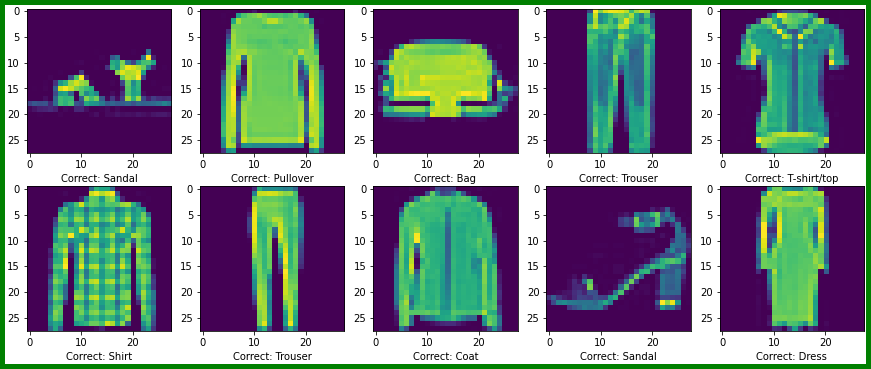

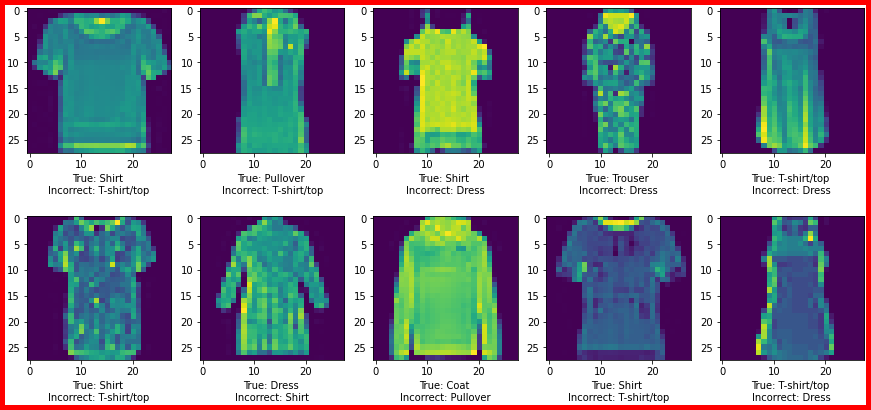

In [17]:
import random
class_dictionary = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
model.to(device=device)
incorrectlabel = show_prediction(loader_test,model, num_correct=10, num_incorrect=10, shuffle_order=True)

Text(0.5, 1.0, 'Incorrect classification')

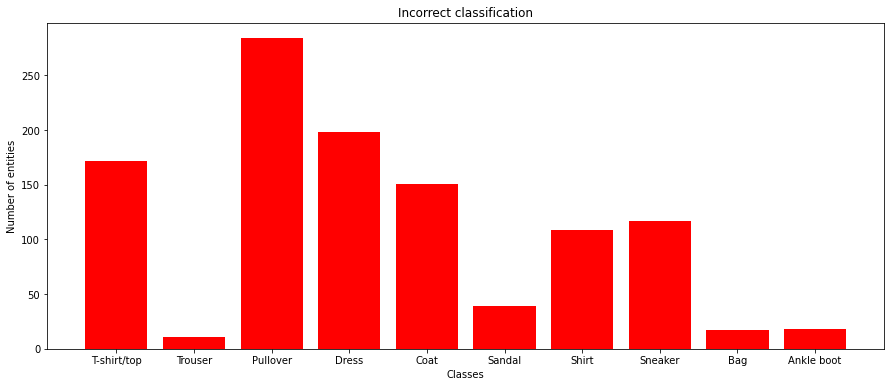

In [18]:
plt.figure(figsize=(15,6))
error_class = []
[error_class.append(incorrectlabel.count(i)) for i in range(10)]
plt.bar(class_dictionary,error_class, color=['red'])
plt.title('')
plt.xlabel('Classes')
plt.ylabel('Number of entities')
plt.title('Incorrect classification')

In [20]:
# Python Image Library (PIL) with python interpreter for image editing.
# Resize image.png from _x_ to 28x28.
# Run to edit dimensions of your image
import os
from PIL import Image
for image_file_name in os.listdir('..//assets//datasets//stickler_for_the_rules_images//'):
    if image_file_name.endswith(".jpg"):
        im = Image.open('..//assets//datasets//stickler_for_the_rules_images//'+image_file_name)
        new_width  = 128
        new_height = 128
        im = im.resize((new_width, new_height))
        im.save('..//assets//datasets//stickler_for_the_rules_images//' + image_file_name)

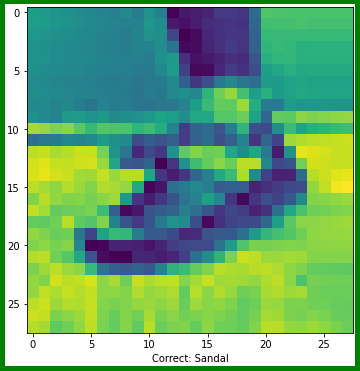

In [21]:
import cv2 
# Cat is number 3 label
True_label = 5 ### Change here the label of your image {'Sandal': 5,'Sneaker': 7,'Ankle boot': 9}
# Open an image by using OpenCV
img = cv2.imread("../myImages/sandals.jpg")
# Converting BGR color to GRAY color format
# RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


# Change to Tensor and normalize data
img_aug = transform(RGB_img)
x = img_aug.to(device=device, dtype=dtype)
# Batch size
scores = model(x.unsqueeze(0))
_, preds = scores.max(1)

# Visualization
image_example = np.transpose(inv_trans(img_aug), (1, 2, 0))
if preds == True_label:
    plt.figure(figsize=(15,6), linewidth=10, edgecolor='green')
    plt.imshow(image_example)
    plt.xlabel('Correct: '+class_dictionary[preds])
else:
    plt.figure(figsize=(15,6), linewidth=10, edgecolor='red')
    plt.imshow(image_example)
    plt.xlabel('True: '+ class_dictionary[True_label]+' \n'+
                   'Incorrect: '+ class_dictionary[preds])